In [1]:
!pip install spacy evaluate seqeval

  Obtaining dependency information for evaluate from https://files.pythonhosted.org/packages/70/63/7644a1eb7b0297e585a6adec98ed9e575309bb973c33b394dae66bc35c69/evaluate-0.4.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=b1b115566cd527383b3046dc13df6c94fd43217086ce610c249f3b064bab33ea
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [2]:
!python -m spacy download uk_core_news_sm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 59.2 MB/s eta 0:00:0000:010:01
  Obtaining dependency information for pymorphy3>=1.0.0 from https://files.pythonhosted.org/packages/d7/f9/ffb9afde503dc6bb2361ea79ceaea18138fbcee32aec4c5d8efa49180753/pymorphy3-1.2.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 22.7 MB/s eta 0:00:0000:0100:01
  Obtaining dependency information for docopt-ng>=0.6 from https://files.pythonhosted.org/packages/6c/4a/c3b77fc1a24510b08918b43a473410c0168f6e657118807015f1f1edceea/docopt_ng-0.9.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 73.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 5.9 MB

In [5]:
import re
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import ipywidgets as widgets
import spacy
import math
import gc
import nltk
import string

from sklearn.model_selection import StratifiedKFold
from typing import List, Tuple
from pprint import pprint
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from tqdm import tqdm
from itertools import chain
from torch import nn
from copy import deepcopy
from nltk import tokenize
from spacy.training.iob_utils import biluo_to_iob, doc_to_biluo_tags
from tqdm.autonotebook import tqdm
tqdm.pandas()

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, DataCollatorForTokenClassification, TrainingArguments, \
    AdamW, get_linear_schedule_with_warmup, Trainer,\
    pipeline
import evaluate
from shutil import rmtree
import warnings
warnings.filterwarnings("ignore")

np.random.seed(98)

In [6]:
INPUT_FOLDER_PATH = '/kaggle/input/nlp-ua-locations-extractions'
WORKING_FOLDER_PATH = '/kaggle/working'

UK_FILE_PATH = INPUT_FOLDER_PATH + "/uk_geo_dataset.csv"
ru_FILE_PATH = INPUT_FOLDER_PATH + "/ru_geo_dataset.csv"
TEST_FILE_PATH = INPUT_FOLDER_PATH + "/test.csv"
TEST_SAMPLE_FILE_PATH = INPUT_FOLDER_PATH + "/labeling_sample.csv"

UKR_TRAIN_FRACTION = 0.15
UKR_TEST_FRACTION = 0.3

LABEL2ID = {'O': 0, 'B-LOC': 1, 'I-LOC': 2, 'B-ORG':3, 'I-ORG': 4, 'B-PER': 5, 'I-PER': 6}
ID2LABEL = {v: k for k, v in LABEL2ID.items()}

In [7]:
uk_geo_dataset = pd.read_csv(UK_FILE_PATH, converters={"loc_markers": eval, 'org_markers': eval, 'per_markers': eval})
ru_geo_dataset = pd.read_csv(ru_FILE_PATH, converters={"loc_markers": eval, 'org_markers': eval, 'per_markers': eval})

test_sample_dataset = pd.read_csv(TEST_SAMPLE_FILE_PATH, converters={"loc_markers": eval, "locations": eval})
test_dataset = pd.read_csv(TEST_FILE_PATH, converters={"locations": eval}, index_col="text_id")

In [8]:
def hard_processing(text):
    text = re.sub(r"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r'\d', '', text)
    text = re.sub(r'\b\w\b\s?', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

def comp_metric(y_true: List[List[str]], y_pred: List[List[str]]):
    assert len(y_true) == len(y_pred)
    tp, fp, fn, p,  = 0.0, 0.0, 0.0, 0.0

    for y_true_sample, y_pred_sample in zip(y_true, y_pred):
        y_true_sample = set([hard_processing(s) for s in y_true_sample])
        y_pred_sample = set([hard_processing(s) for s in y_pred_sample])

        tp += len(y_true_sample & y_pred_sample)
        fp += len(y_pred_sample - y_true_sample)
        fn += len(y_true_sample - y_pred_sample)
        p += len(y_true_sample)

    if tp + fp == 0:
        if p == 0:
            precision = 1.0
        else:
            precision = 0.0
    else:
        precision = tp/(tp + fp)

    if tp + fn == 0:
        if p == 0:
            recall = 1.0
        else:
            recall = 0.0
    else:
        recall = tp/(tp + fn)

    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * precision * recall / (precision + recall)
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

<a id="data-preparation"></a>
## Data preparation

In [9]:
russian_docs = ru_geo_dataset.loc[:, 'doc_id'].unique().astype(int)

test_ru_docs = np.random.choice(russian_docs, 200)
test_ru_docs[:20]

array([384474, 647757, 216244, 560597, 280641,  56004, 307271,  58857,
       566061, 450564, 479052, 529309, 684479, 134106, 160463, 118759,
       683777, 300806,    340, 561375])

In [10]:
ru_geo_dataset.loc[:, "is_valid"] = 0
ru_geo_dataset.loc[ru_geo_dataset['doc_id'].isin(test_ru_docs), "is_valid"] = 1

In [11]:
TEST_PROPORTION_RU = 0.09

In [12]:
df_ukr_train = uk_geo_dataset[~uk_geo_dataset.is_valid.astype(bool)].sample(frac=UKR_TRAIN_FRACTION)
df_ukr_valid = uk_geo_dataset[uk_geo_dataset.is_valid.astype(bool)].sample(frac=UKR_TEST_FRACTION)
df_ukr_locations = pd.concat([df_ukr_train, df_ukr_valid], axis=0)

df_ru_train = ru_geo_dataset[~ru_geo_dataset.is_valid.astype(bool)].sample(n=int(TEST_PROPORTION_RU*len(df_ukr_train)))
df_ru_valid = ru_geo_dataset[ru_geo_dataset.is_valid.astype(bool)].sample(n=int(TEST_PROPORTION_RU*len(df_ukr_valid)))
df_ru_locations = pd.concat([df_ru_train, df_ru_valid], axis=0)

In [13]:
print(f"Ukrainian docs:\n- {len(df_ukr_locations)} total sentences;\n- {(df_ukr_locations.is_valid == 1).sum()} test sentences")
print(f"russian docs:\n- {len(df_ru_locations)} total sentences;\n- {(df_ru_locations.is_valid == 1).sum()} test sentences")

Ukrainian docs:
- 153000 total sentences;
- 3000 test sentences
russian docs:
- 13770 total sentences;
- 270 test sentences


In [14]:
df_ukr_locations.loc_markers = df_ukr_locations.loc_markers.apply(lambda x: [[y[0], y[1], 'LOC']  for y in x])
df_ukr_locations.org_markers = df_ukr_locations.org_markers.apply(lambda x: [[y[0], y[1], 'ORG']  for y in x])
df_ukr_locations.per_markers = df_ukr_locations.per_markers.apply(lambda x: [[y[0], y[1], 'PER']  for y in x])

df_ru_locations.loc_markers = df_ru_locations.loc_markers.apply(lambda x: [[y[0], y[1], 'LOC']  for y in x])
df_ru_locations.org_markers = df_ru_locations.org_markers.apply(lambda x: [[y[0], y[1], 'ORG']  for y in x])
df_ru_locations.per_markers = df_ru_locations.per_markers.apply(lambda x: [[y[0], y[1], 'PER']  for y in x])

In [15]:
nlp = spacy.blank("xx")

def convert_to_conll(row, test=False, text_col = 'text'):
    data = {
        "text": row[text_col]
    }
    doc = nlp(data["text"])
    if test:
        return list([t.text for t in doc])
    
    labels_candidates = sorted(row['loc_markers'] + row['org_markers'] + row['per_markers'])
    data['label'] = []
    for i, (start, end, label) in enumerate(labels_candidates):
        if i > 0:
            if data['label'][-1][1] > start:
                continue
                
        data['label'].append([start, end, label])
    
    ents = []
    for start, end, label in data["label"]:
        span = doc.char_span(start, end, label=label)
        if span is not None:
            ents.append(span)
        else:
            chosen = [w for i, w in enumerate(doc) if (w.idx > start) and (w.idx + len(w.text) < end)]
            if len(chosen) == 0:
                continue
            span_start = chosen[0].idx
            span_end = chosen[-1].idx + len(chosen[-1].text)
            corrected_span = doc.char_span(span_start, span_end, label=label)
            if corrected_span is not None:
                ents.append(corrected_span)
            else:
                print(
                    "Skipping corrected span (does not align to tokens):",
                    start,
                    end,
                    label,
                    doc.text[start:end],
                )
    try:
        doc.ents = ents
    except ValueError as e:
        print(data['label'])
        print(ents)
        
        raise e
    return pd.Series({
        'conll_tokens': list([t.text for t in doc]),
        'conll_labels': list(biluo_to_iob(doc_to_biluo_tags(doc)))
    })

In [16]:
df_ukr_locations.loc[:, ["conll_tokens", "conll_labels"]] = df_ukr_locations.progress_apply(convert_to_conll, axis=1)
df_ru_locations.loc[:, ["conll_tokens", "conll_labels"]] = df_ru_locations.progress_apply(convert_to_conll, axis=1)

  0%|          | 0/153000 [00:00<?, ?it/s]

  0%|          | 0/13770 [00:00<?, ?it/s]

In [17]:
df_ukr_locations, df_ukr_locations_holdout_test = df_ukr_locations[df_ukr_locations["is_valid"] == 0].reset_index(drop=True), df_ukr_locations[df_ukr_locations["is_valid"] == 1].reset_index(drop=True)
df_ru_locations, df_ru_locations_holdout_test = df_ru_locations[df_ru_locations["is_valid"] == 0].reset_index(drop=True), df_ru_locations[df_ru_locations["is_valid"] == 1].reset_index(drop=True)
df_holdout_test = pd.concat([df_ukr_locations_holdout_test, df_ru_locations_holdout_test], axis=0)

In [18]:
df_ukr_locations["stratify_col"] = df_ukr_locations["loc_markers"].apply(len)
df_ukr_locations.loc[df_ukr_locations["stratify_col"] >= 10, "stratify_col"] = -1
df_ukr_locations["stratify_col"].value_counts()

stratify_col
 0    115274
 1     24029
 2      7156
 3      2226
 4       741
 5       294
 6       136
 7        56
 8        39
 9        25
-1        24
Name: count, dtype: int64

In [19]:
skf_ukr = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
folds_train_test_ids_ukr = [el for el in skf_ukr.split(df_ukr_locations, df_ukr_locations["stratify_col"])]

ukr_locations_train_ids, ukr_locations_val_ids = folds_train_test_ids_ukr[0]
df_ukr_locations_train = df_ukr_locations.loc[ukr_locations_train_ids]
df_ukr_locations_val = df_ukr_locations.loc[ukr_locations_val_ids]

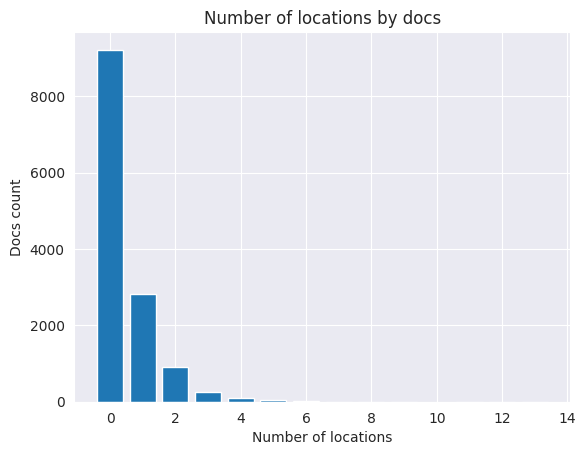

In [21]:
df_ru_locations.loc[:, "number_of_locations"] = df_ru_locations["loc_markers"].apply(len)

docs_ru_locs_counts = df_ru_locations.groupby('doc_id').agg({'number_of_locations': 'sum'})

docs_ru_locs_counts_freqs = docs_ru_locs_counts['number_of_locations'].value_counts()

plt.bar(docs_ru_locs_counts_freqs.keys(), docs_ru_locs_counts_freqs.values)
plt.title("Number of locations by docs")
plt.ylabel("Docs count")
plt.xlabel("Number of locations")
plt.show()

In [22]:
min_cocs_ru_freqs = min(docs_ru_locs_counts_freqs[docs_ru_locs_counts_freqs.values < 10].keys())
min_cocs_ru_freqs

7

In [23]:
df_ru_locations.loc[:, "stratify_col"] = docs_ru_locs_counts.loc[df_ru_locations.loc[:, 'doc_id']].values
df_ru_locations.loc[df_ru_locations.loc[:, "stratify_col"] >= min_cocs_ru_freqs, "stratify_col"] = -1

In [24]:
skf_ru = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
folds_train_test_ids_ru = [el for el in skf_ru.split(df_ru_locations, df_ru_locations["stratify_col"])]

ru_locations_train_ids, ru_locations_val_ids = folds_train_test_ids_ru[0]
df_ru_locations_train = df_ru_locations.loc[ru_locations_train_ids]
df_ru_locations_val = df_ru_locations.loc[ru_locations_val_ids]

In [25]:
df_train = pd.concat([df_ru_locations_train, df_ukr_locations_train], axis=0)
df_val = pd.concat([df_ru_locations_val, df_ukr_locations_val], axis=0)

In [26]:
df_train.loc[:, 'ner_tags'] = df_train['conll_labels'].apply(lambda x: [LABEL2ID[t] for t in x])
df_val.loc[:, 'ner_tags'] = df_val['conll_labels'].apply(lambda x: [LABEL2ID[t] for t in x])
df_holdout_test.loc[:, 'ner_tags'] = df_holdout_test['conll_labels'].apply(lambda x: [LABEL2ID[t] for t in x])

In [27]:
df_train

,text,loc_markers,org_markers,per_markers,doc_id,sent_id,is_valid,conll_tokens,conll_labels,number_of_locations,stratify_col,ner_tags
1,Стоимость федеральной программы США по замене ...,"[[32, 35, LOC]]",[],[],573140.0,0.0,0,"[Стоимость, федеральной, программы, США, по, з...","[O, O, O, B-LOC, O, O, O, O, O, O, O, O, O, O,...",1.0,1,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Рассказывая о своей встрече с главой российско...,"[[93, 99, LOC]]","[[49, 52, ORG]]","[[53, 68, PER], [70, 79, PER]]",702324.0,4.0,0,"[Рассказывая, о, своей, встрече, с, главой, ро...","[O, O, O, O, O, O, O, B-ORG, B-PER, I-PER, O, ...",1.0,1,"[0, 0, 0, 0, 0, 0, 0, 3, 5, 6, 0, 5, 0, 0, 0, ..."
3,Второй сингл «Moving» группа выпустила 1 июля.,[],[],[],263240.0,5.0,0,"[Второй, сингл, «, Moving, », группа, выпустил...","[O, O, O, O, O, O, O, O, O, O]",0.0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,Президент России приветствует заявление Буша о...,"[[10, 16, LOC], [56, 65, LOC], [87, 94, LOC], ...","[[238, 256, ORG]]","[[40, 44, PER]]",710071.0,2.0,0,"[Президент, России, приветствует, заявление, Б...","[O, B-LOC, O, O, B-PER, O, O, O, O, B-LOC, O, ...",5.0,5,"[0, 1, 0, 0, 5, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, ..."
5,Группа американских и британских ученых отправ...,"[[63, 69, LOC]]",[],[],497709.0,2.0,0,"[Группа, американских, и, британских, ученых, ...","[O, O, O, O, O, O, O, O, O, B-LOC, O, O, O, O,...",1.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
149994,"Кураєв додав, що Японія дотримується тієї ж ду...","[[17, 23, LOC], [86, 91, LOC]]",[],"[[0, 6, PER]]",NaN,NaN,0,"[Кураєв, додав, ,, що, Японія, дотримується, т...","[B-PER, O, O, O, B-LOC, O, O, O, O, O, O, O, O...",NaN,2,"[5, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
149995,Соціологи підтверджують: у нас непристойно баг...,[],[],[],NaN,NaN,0,"[Соціологи, підтверджують, :, у, нас, непристо...","[O, O, O, O, O, O, O, O, O, O, O, O, O]",NaN,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
149996,"Виїздом на місце події було встановлено, що чо...",[],[],[],NaN,NaN,0,"[Виїздом, на, місце, події, було, встановлено,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]",NaN,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
149998,"По-друге, це може уповільнити ваш метаболізм і...",[],[],[],NaN,NaN,0,"[По, -, друге, ,, це, може, уповільнити, ваш, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",NaN,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [28]:
df_train[['conll_tokens', 'ner_tags']].to_json(
    '/train_processed.json', orient='records', lines=True)
df_val[['conll_tokens', 'ner_tags']].to_json(
    '/valid_processed.json', orient='records', lines=True)

<a id="modelling"></a>
## Modelling

In [29]:
raw_datasets = load_dataset(
    "json",
    data_files={
        'train': '/train_processed.json',
        'val': '/valid_processed.json',
    }
)
raw_datasets

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-203a57579bb19ec0/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['conll_tokens', 'ner_tags'],
        num_rows: 130800
    })
    val: Dataset({
        features: ['conll_tokens', 'ner_tags'],
        num_rows: 32700
    })
})

In [30]:
model = AutoModelForTokenClassification.from_pretrained(
    'xlm-roberta-base',
    id2label=ID2LABEL,
    label2id=LABEL2ID,
)
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as previous token
            label = labels[word_id]
            # If the label is B-XXX we change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["conll_tokens"], truncation=True, is_split_into_words=True
    )
    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

In [32]:
tokenized_datasets = raw_datasets.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)

  0%|          | 0/131 [00:00<?, ?ba/s]

  0%|          | 0/33 [00:00<?, ?ba/s]

In [33]:
args = TrainingArguments(
    "roberta-loc-ner",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy="steps",
    eval_steps = 0.1,
    save_strategy="steps",
    save_steps = 0.2,
    num_train_epochs=1
)

optimizer = AdamW([
    {'params': list(model.roberta.parameters()), 'lr': 1e-5},
    {'params': list(model.classifier.parameters()), 'lr': 1e-3}
])

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0.1*1*(tokenized_datasets['train'].num_rows/16),
    num_training_steps=1*(tokenized_datasets['train'].num_rows/16)
)

In [34]:
metric = evaluate.load("seqeval")

label_names = list(LABEL2ID.keys())

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"]
    }

In [35]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["val"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    optimizers=(optimizer, scheduler)
)
trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Precision,Recall,F1
205,No log,0.209441,0.278172,0.218661,0.244853
410,No log,0.062286,0.726889,0.820331,0.770788
615,0.584800,0.051555,0.786165,0.857008,0.820059
820,0.584800,0.049783,0.787549,0.857823,0.821185
1025,0.054500,0.043777,0.817880,0.867636,0.842024
1230,0.054500,0.042513,0.814393,0.876602,0.844353
1435,0.054500,0.041258,0.823017,0.864767,0.843375
1640,0.045400,0.041275,0.824826,0.880840,0.851913
1845,0.045400,0.039105,0.844547,0.880644,0.862218


TrainOutput(global_step=2044, training_loss=0.17900381028768833, metrics={'train_runtime': 2998.3069, 'train_samples_per_second': 43.625, 'train_steps_per_second': 0.682, 'total_flos': 4819632400065120.0, 'train_loss': 0.17900381028768833, 'epoch': 1.0})

<a id="validation"></a>
## Validation & Postprocessing

In [36]:
model_checkpoint = "/kaggle/working/roberta-loc-ner/checkpoint-1227/"
token_classifier = pipeline(
    "token-classification", model=model_checkpoint, aggregation_strategy="simple", batch_size=32
)

### Validation predictions

In [37]:
def extract_loc_targets(row):
    text = row['text']
    markers = row['loc_markers']
    
    res = []
    for start, end, _ in markers:
        res.append(text[start:end])
    return res

In [38]:
val_classification = token_classifier(df_val["text"].tolist()[:1000])
y_val_true = df_val.apply(extract_loc_targets, axis=1)

### Test predictions

In [39]:
%%time

test_classification = token_classifier(df_holdout_test["text"].tolist())
test_classification

CPU times: user 6min 3s, sys: 6.57 s, total: 6min 10s
Wall time: 3min 8s


[[],
 [{'entity_group': 'ORG',
   'score': 0.6059428,
   'word': 'стерШеф',
   'start': 45,
   'end': 52}],
 [{'entity_group': 'PER',
   'score': 0.99908197,
   'word': 'Андрій Тлумак',
   'start': 31,
   'end': 44},
  {'entity_group': 'ORG',
   'score': 0.8351018,
   'word': '«Агробізнес',
   'start': 90,
   'end': 101},
  {'entity_group': 'ORG',
   'score': 0.9037684,
   'word': '«Руху»',
   'start': 127,
   'end': 133}],
 [],
 [],
 [],
 [],
 [{'entity_group': 'ORG',
   'score': 0.96305954,
   'word': 'НБУ',
   'start': 40,
   'end': 43},
  {'entity_group': 'ORG',
   'score': 0.7524488,
   'word': 'Гроші',
   'start': 46,
   'end': 51},
  {'entity_group': 'ORG',
   'score': 0.9295103,
   'word': 'TCH.',
   'start': 54,
   'end': 58}],
 [],
 [],
 [{'entity_group': 'ORG',
   'score': 0.8756922,
   'word': 'Манчестер Сіті',
   'start': 11,
   'end': 25},
  {'entity_group': 'ORG',
   'score': 0.7166709,
   'word': 'Вест Хема"',
   'start': 48,
   'end': 58},
  {'entity_group': 'ORG',
   

In [41]:
y_test_pred = []
best_thresh = 0.8

for row_labels in test_classification:
    res = []
    for found_info in row_labels:
        if found_info['entity_group'] == 'LOC' and found_info['score'] > best_thresh:
            res.append(found_info['word'])
            
    y_test_pred.append(res)

In [42]:
y_test_true = df_holdout_test.apply(extract_loc_targets, axis=1)

In [43]:
comp_metric(y_test_true, y_test_pred)

{'precision': 0.950682056663169,
 'recall': 0.8296703296703297,
 'f1': 0.8860635696821516}

In [44]:
def extract_loc_targets_sample(row):
    text = row['text']
    markers = row['loc_markers']
    
    res = []
    for start, end in markers:
        res.append(text[start:end])
    return res

In [46]:
best_thresh = 0.82

In [58]:
df_test = pd.read_csv('/kaggle/input/nlp-ua-locations-extractions/test.csv')
df_test['pred'] = token_classifier(df_test["text"].tolist())

In [59]:
df_test.head()

,text_id,text,locations,pred
0,0,"❗️Кількість поранених зросла до трьох, – Кличк...",[],"[{'entity_group': 'PER', 'score': 0.93515867, ..."
1,1,"🥤В Києві за 91,13 млн гривень починаються робо...",[],"[{'entity_group': 'LOC', 'score': 0.9977005, '..."
2,2,▪️Сьогодні вночі росіяни завдали ракетного уда...,[],"[{'entity_group': 'LOC', 'score': 0.9765199, '..."
3,3,Наразі у запасах росіян найбільше балістичних ...,[],"[{'entity_group': 'ORG', 'score': 0.4973969, '..."
4,4,"⛸В один день, 29 серпня, ДП ""Центральна учбово...",[],"[{'entity_group': 'ORG', 'score': 0.8745353, '..."


In [66]:
threshold = 0.8
res = []
for row_labels in df_test['pred']:
    temp = []
    for found_info in row_labels:
        if found_info['entity_group'] == 'LOC' and found_info['score'] > best_thresh:
            temp.append(found_info['word'])
    res.append(temp)
res

[[],
 ['Києві', 'Шулявського шляхопроводу'],
 ['Гоголеве', 'Миргородського району', 'Полтавської області'],
 [],
 ['проспекті Академіка Глушкова, 9.'],
 ['Броварах'],
 ['Брянськ'],
 ['Забуччя', 'Київ'],
 [],
 ['Солом’янському районі столиці', 'вулиці Новій', 'Солом’янському районі'],
 ['олонь'],
 ['Києва', 'Варшави'],
 [],
 [],
 ['Києві'],
 [],
 ['Києві', 'Житомирщині', 'РФ'],
 [],
 [],
 ['Києві', 'олонь'],
 [],
 ['Дарницькому районі', 'Дарницькому районі'],
 ['Лісовий проспект 6-14 Повер'],
 ['Києві', 'Нову', 'Солом’янському районі'],
 ['Україні', 'Україна', 'Харківщини'],
 ['Шевченківському районі', 'вул. Димитрівська, 4'],
 [],
 [],
 ['Криму', 'Україні', 'Київ'],
 ['Дмитровской'],
 [],
 ['ул. Дмитриевская'],
 [],
 ['Шевченківський район'],
 ['Новій Каховці'],
 ['Дарницькому районі', 'Шевченківському районі столиці', 'Києві'],
 ['вулиці Гоголівська', 'вулицю Шевченківська'],
 ['Київ'],
 ['Київ'],
 ['Київщині', 'Білоцерківському районі', 'Київ'],
 ['вул. Князів Острозьких'],
 ['Україн

In [64]:
df_test['locations'] = res
df_test

,text_id,text,locations,pred
0,0,"❗️Кількість поранених зросла до трьох, – Кличк...",[],"[{'entity_group': 'PER', 'score': 0.93515867, ..."
1,1,"🥤В Києві за 91,13 млн гривень починаються робо...","[Києві, Шулявського шляхопроводу]","[{'entity_group': 'LOC', 'score': 0.9977005, '..."
2,2,▪️Сьогодні вночі росіяни завдали ракетного уда...,"[Гоголеве, Миргородського району, Полтавської ...","[{'entity_group': 'LOC', 'score': 0.9765199, '..."
3,3,Наразі у запасах росіян найбільше балістичних ...,[],"[{'entity_group': 'ORG', 'score': 0.4973969, '..."
4,4,"⛸В один день, 29 серпня, ДП ""Центральна учбово...","[проспекті Академіка Глушкова, 9.]","[{'entity_group': 'ORG', 'score': 0.8745353, '..."
...,...,...,...,...
472,472,Допомога на відновлення: п’ять громад Київщини...,"[Київщини, Україні, Київської області, Бучансь...","[{'entity_group': 'LOC', 'score': 0.99186313, ..."
473,473,Пророцтво Стругацьких: незвичайна бактерія Бра...,[],"[{'entity_group': 'PER', 'score': 0.9455178, '..."
474,474,Із 1 вересня УГКЦ і ПЦУ перейшли на новий церк...,[],"[{'entity_group': 'ORG', 'score': 0.9568253, '..."
475,475,🦇 У Києві з Дніпра виловили іноземця в масці Б...,"[Києві, Дніпра, Дніпро]","[{'entity_group': 'LOC', 'score': 0.9985114, '..."


In [65]:
df_test[['text_id', 'locations']].to_csv('roberta.csv', index=False)